## Logistic Regression - Survival onboard the RMS Titanic

James Kennedy 16.04.2020

This post is a learning resource to compliment Coursera's Machine Learning course which I recently completed. The goal is to manually fit a logistic regression to get my head around the inner workings. I'm going to use the Titanic dataset from Kaggle to make predictions about which passengers survived the shipwreck.

1. TOC
{:toc}

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data_raw = pd.read_csv('train.csv')
data = data_raw.copy()

### Data Preprocessing ###

While data preprocessing is said to be the most important step in building a high performance model I am going to skim through this stage in order to train a model quickly as the goal of this workbook isn't model performance. I will follow up this post with another on optimising performance.

In [2]:
# Fill missing ages with the dataset average
data.Age = data.Age.fillna(data.Age.mean())

# Fill missing embarkment port with the mode
data.Embarked = data.Embarked.fillna('S')

# Convert categorical features into numeric and drop unused ones
data = pd.get_dummies(data, columns = ['Sex', 'Embarked'])
data.drop(columns=['SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Name', 'PassengerId'], inplace=True)

# Drop target and convert to matrix, dimensions observations * features
features = data.drop(columns=['Survived']).to_numpy()

# Add intercept feature initalised as vector of zeros
features = np.column_stack((np.ones(len(features)), features))

# Initalise parameters as vector of zeros
parameters = np.zeros(8)

# Convert target to numpy array
target = data['Survived'].to_numpy()

# Feature names
feature_names = data.columns[1:]
feature_names = feature_names.insert(0,'Bias Term')

print(f'Model Survival as a function of {", ".join(feature_names)+"."}')

Model Survival as a function of Bias Term, Pclass, Age, Sex_female, Sex_male, Embarked_C, Embarked_Q, Embarked_S.


### Model Form ###

Logistic regression is a classification algorithm that predicts the probablity that an observation belongs to a class. For our purposes we will use information about each passinger, their age, sex, etc, to estimate the probability that they survivied the long night at sea in 1912. 

In machine learning logistic regression is categorised as one of the linear models, along with linear regression - no points awarded for that one. My understanding is that the important class attribute of being a linear model is the model features being added together to constitute the output, as opposed to using multiplication or exponents. 

Displaying our model form with logistic regression is a two part process. Function Z below is a linear combination of the product of our paramaters (B0, B1, ..., Bn) & features from the Titanic dataset. I know I *just said* that the class quality of linear models precludes multiplication in the model form but the heavenly father has confirmed to me that this doesn't constitute a breach.

*Z = B0xBiasTerm + B1xPclass + B2xAge + B3xSex_female + B4xSex_male + B5xEmbarked_C + B6xEmbarked_Q + B7xEmbarked_S*

Z at present can take on any real number depending on it's parameters. This won't serve as a probabilistic prediction given probabilities must only take on values between 0 & 1. *Honey it's bad news... they said they were 110% sure...* To make predictions we need to transform the output of Z with the Sigmoid function that maps any real number to a value between 0 & 1.

*Sigmoid(x) = 1/(1 + exp(-x))*

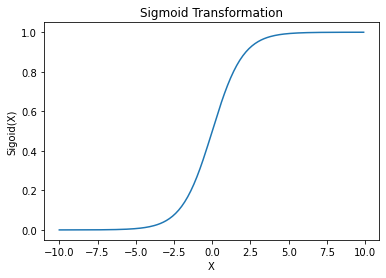

<Figure size 432x288 with 0 Axes>

In [6]:
# Create dummy range of values & transform with sigmoid function
x = np.arange(-10, 10, 0.1)
sigmoid = 1/(1 + np.exp(-x))

# Plot sigmoid function of x showing values between 0 and 1 for any value of x
fig, ax = plt.subplots()
ax.plot(x, sigmoid)
ax.set(title='Sigmoid Transformation', xlabel='X', ylabel='Sigoid(X)')
plt.show()
plt.savefig("sigmoid.jng")

Passing the output of Z through the Sigmoid function gives us our prediction. Taken together our model form is the below two statements.

*Z = B0x0 + B1xPclass + B2xAge + B3xSex_female + B4xSex_male + B5xEmbarked_C + B6xEmbarked_Q + B7xEmbarked_S*

*Prediction = Sigmoid(Z)*

The final piece of the puzzle is a threshold above which we actually predict survival. 50% is an intuitive threshold so if we predict >= 50% we will have offically granted a second chance, else they're a goner.

*Predict Survival if Sigmoid(Z) >= 0.5 else Deceased*

In [4]:
# Vectorised predictive function
def predict(features, parameters):
    z = np.matmul(features,parameters)
    predictions = 1/(1 + np.exp(-z))
    return predictions

### Model Fit###

Given our model form, how do we come up with parameters such that the predictions are sensible?

This is a two fold problem. 

Our model is going to make predictions using its parameters. Given this a supervised learning problem we have labelled training data that tells us the actual value for what we are trying to predict. We need an evaluation metric that quantifies whether our predictions stack up with what actually happened, in machine learning the general term for such a metric is called the cost function.

#### Cost Function ####

Cost as a general metric invokes loss, error, miscalculation so however its tallied up we want it minimised. Prior to the mathematics let's think generally about how the cost function might work given our predicament. 

We know whether each individual in our dataset survived the shipwreck and we are building a model that is going to predict for each individual the likeihood of survival. Accesing each individual iteratively we can tally a penalty for each prediction that is low when the model is on the right track and high when it's barking up the wrong tree. Our model makes predictions between 0 & 1 but, given the sigmoid transformation, it never actually predicts with 100% certainty. So when our model predicts with a high degree of certainty, >80%, that an individual survived when they in fact did we don't want it to be penalised very much. Equally if the model predicts with high certainty that an individual survived when they were in fact at the bottum of the sea we want a substantial penalty applied.

If we were accessing multiple models with the same form but different parameters it would be sensible to favour the model with the lowest average cost tallied in such a manner. Hopefully this seems intuitive.

The cost function used to evaluate logistical regression is defined by Andrew Ng below. I am going to explore how it works with hypothetical data.

![title](cost_function_log_reg.png)


In [5]:
# Generate dummy target & predictions
target_ = np.array([0, 1, 0, 1, 0]) 
predictions_ = np.array([0.009, 0.99, 0.5, 0.01, 0.99])

# Number of obsersations
observations_ = len(target_)

# For each observation there are two seperate cost components
arr = np.zeros(5)
for i in range(observations_):
    y, x = target_[i], predictions_[i]
    cost_y_1 = -y*np.log(x)
    cost_y_0 = (1-y)*np.log(1-x)
    cost = cost_y_1 - cost_y_0
    arr[i] = cost
    print(f'For observation {i} the cost is {round(cost_y_1,4)} for y=1 and {round(cost_y_0,4)} for y=0')

cost = round(arr.mean(),3)
print(f'The total cost for the model used to generate our predictions is {cost} this is the mean of the cost from each observation')

For observation 0 the cost is -0.0 for y=1 and -0.009 for y=0
For observation 1 the cost is 0.0101 for y=1 and -0.0 for y=0
For observation 2 the cost is -0.0 for y=1 and -0.6931 for y=0
For observation 3 the cost is 4.6052 for y=1 and -0.0 for y=0
For observation 4 the cost is -0.0 for y=1 and -4.6052 for y=0
The total cost for the model used to generate our predictions is 1.985 this is the mean of the cost from each observation


The above output displays the results of applying the cost function to each dummy observation in turn. The first observation to note is that the penalty has two components for each observation. One component is calculated with reference to the target being 1 and the other for the target being 0. This is purely a neat way to represent that in each case the penalty refers to the actual value of the target. So intuitively the penalty component for y=1 is only non-zero when y=1 and vice versa for y=0.

From the output we can see that the penalty is small for observations 0 & 1 because the prediction was close to reality. Equally we had a comparatively large penalty for observations 3 & 4 because the predictions were way off. The model was uncertain about observation 2 assiging it a 50% probabilty of being 1. 

In order to appreciate how the penalty changes with changes in the prediction we can plot the penalty as a function of the prediction.

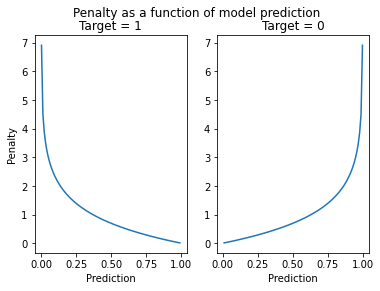

In [6]:
# Dummy predictions & costs 
x_1 = np.arange(0.001, 0.999, 0.01)
x_0 = np.arange(0.999, 0.001, -0.01)
cost_1 = -1*np.log(x_1)
cost_0 = -np.log(1-x_0)

# Plot predictions against cost
fig, ax = plt.subplots(1, 2)
fig.suptitle('Penalty as a function of model prediction')
ax[0].plot(x_1, cost_1)
ax[0].set(xlabel='Prediction', ylabel='Penalty')
ax[0].set_title('Target = 1')
ax[1].plot(x_0, cost_0)
ax[1].set(xlabel='Prediction')
ax[1].set_title('Target = 0')
plt.show()

We have two plots as the penalty applied references the actual value of the target. We can see that the cost of our prediction is close to zero when our model is very certain and correct, ie predicting 0.999 when the target is equal to 1. 

The cost grows exponentially when the model predicts with high certainity incorrectly, ie predicting 0.999 when the target is 0. We can also see that the penality is small when the model is pretty sure and correct, ie predicting 0.8 when the target is equal to 1. This all sounds sensible. 

The cost function's inner mechanics directly match up with our intuitive ideas about how it ought to work. It iteratively applies a penalty to each model prediction that grows exponentially the further off from reality the prediction is. The cost of the model given a set of parameters is the average cost of it's predictions. Hopefully we can now appreciate that the ostensibly scarey formula above is really just a concise expression for intuitve process. 

Below is a vectorised implementation of the cost function. Let's calculate the cost of model for the Titanic dataset with parameters initialised at zero. Given the parameter values are all zero the models prediction will be 0.5 for all observations and therefore the cost will be equal to 0.693.

In [7]:
def cost_logistic_regression(features, parameters, target): 
    observations = len(features)
    predictions = predict(features, parameters)
    cost_positive_class = -target * np.log(predictions) 
    cost_negative_class = (1 - target) * np.log(1-predictions)
    cost = cost_positive_class - cost_negative_class
    cost = cost.sum() / observations
    return cost

cost = cost_logistic_regression(features, parameters, target)
print(f'Cost of model with zero initialised parameters: {round(cost,3)}')

Cost of model with zero initialised parameters: 0.693


#### Parameter fitting ####

We can use the cost function to evaluate our model given a set of parameters and we can use this metric to favour one model over another given the model with the lowest cost will explain the training data better. This says nothing about how well a model generalises but that's for another day.

Our model for the Titanic dataset has 8 parameters corresponding to our 7 features and the bias term - *don't ask*. Each one of these parameters can take on any real number as a value, so how do we go about finding the parameter values that minimise our cost function?

I'm going to use another hypothetical example to examine how the cost function changes with changes in parameter value.

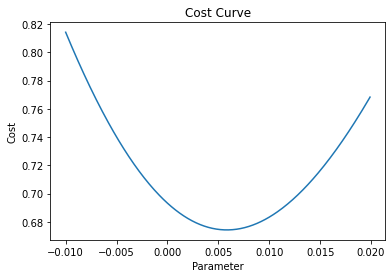

In [8]:
# Create dummy features & target
features_ = np.array([40, 60, 80, 15, 88, 70, 90, 35, 50, 97])
target_ = np.array([0, 0, 1, 0, 1, 1, 1, 0, 1, 0])

# Add zero valued bias term so we can use vectorised cost function
features_ = np.column_stack((np.zeros(len(features_)), features_)) 

# Compute cost function over a range of parameter values
sample_parameters = np.arange(-0.01, 0.02, 0.0001)

costs = np.zeros(len(sample_parameters))
i = 0

for b in np.nditer(sample_parameters):
    parameters_ = np.array([0, b])
    cost = cost_logistic_regression(features_, parameters_, target_)
    costs[i] = cost
    i += 1
    
# Plot cost as a function of the parameter values
fig, ax = plt.subplots()
ax.plot(sample_parameters, costs)
ax.set(title='Cost Curve', xlabel='Parameter', ylabel='Cost')
plt.show()

Above is the cost function as a function of our single parameter b. Notice the convex relationship. In this simplified example we can see the value for our single parameter b that minimises the cost function, approximately 0.006. 

What if our model requires more than one parameter? If optimising for 2 parameters we could use a three dimensional plot but anymore than 2 and we will loss the ability to visually solve for the optimal parameters. This is going to be a problem given we have 8 parameters.

So we need another solution beyond visual identification. To this end we use gradient descent. Gradient descent is an optimisation algorithm that takes iterative steps from a defined starting point towards a set of values that minimise a function. For our use case gradient descent takes a set of initial model parameters and returns an updated set that result in a lower value for our cost function. It works by calculating how the cost function changes for changes in our parameters.

Andrew Ng defines gradient descent for use in fitting paramters with the below formula. Given a cost function we want to simultaneously update the values of the parameters by a learning rate (a) * the partial derivative of the cost function with respect to the parameter being updated (that's the ulgly looking thing on the right of a). Mathematicians have deduced proofs for the partial derivatives that are beyond me and the scope of this post. However this doesn't prevent us from understanding how they are used in gradient descent.

![title](grad_update_rule.png)

The partial derivative of a cost function with multiple parameters with respect to parameter b is the rate of change in the cost function given a change in parameter b, holding all other parameters constant.

That's a mouthful. Let's try and break it down.

Given a straight line function the slope is an expression of the rate of change of one variable in terms of another. If the slope of y = f(x) is 2 we know that as x increases by 1 y increases by 2. The beauty of a straight line function is that the slope, and thereby *the rate of change*, is constant. We can easily calculate the slope of a straight line by taking any two points on the line and calculating rise/run. Cost as a function of parameter b above is not a straight line, it is a curve with a slope and thereby a rate of change that is *constantly* changing. Instead of using two points to calculate the slope we could plot a tangential line that just touches the curve at the point where the parameter = b. The slope of this tangential line would then be an approximation for the slope of the curve at that particular point. We can think of the partial derivatives as the slope of this tangential line at the point on the cost curve where the parameter = b.

This is the first theoretical mound we need to climb - the partial derivative of a cost function with multiple parameters with respect to parameter b is the rate of change in the cost function given a change in parameter b, holding all other parameters constant. Let's calculate the partial derivative at a specific point using the same example above and plot a tangential line.

Using the equation above the slope of the cost curve at b = 0 is -6.55


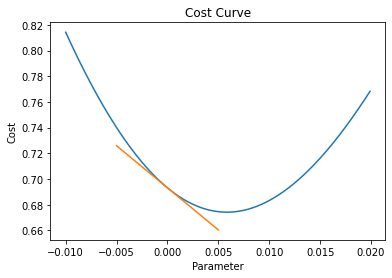

In [9]:
# Solve for the derivative of the cost curve for parameters = 0
observations_ = len(features_)
b = 0
parameters_ = np.array([0, b])
predictions_ = predict(features_, parameters_)
slope = np.matmul(features_.T, predictions_-target_)
slope /= observations_
cost = cost_logistic_regression(features_, parameters_, target_)
print(f'Using the equation above the slope of the cost curve at b = {b} is {slope[1]}')

# Compute coordinates for a tangential line given slope and initial coordinates
def compute_tangent(b, cost, slope, change_b=0.005):
    b1 = b + change_b
    b2 = b - change_b
    cost1 = cost + ((change_b) * slope) 
    cost2 = cost + ((-change_b) * slope) 
    dummy_b = np.linspace(b2, b1, 10)
    dummy_cost = np.linspace(cost2, cost1, 10)
    return dummy_b, dummy_cost

# Plot tangential line to cost curve at b = 0 
dummy_b, dummy_cost = compute_tangent(b, cost, slope[1])
fig, ax = plt.subplots()
ax.plot(sample_parameters, costs)
ax.plot(dummy_b, dummy_cost)
ax.set(title='Cost Curve', xlabel='Parameter', ylabel='Cost')
plt.show()

Now if we were to plot another tangential line that just touches the point on the cost curve where the cost is at it's lowest the slope would be approximately 0 and the corresponding value of b would be the optimal value.

Given the partial derivative calculates the slope of the cost curve at the point where our parameter = b and we know that we want to eventually reach a point where the partial derivative is approximately 0 we can iteratively change the value of b and see what happens to the partial derivative. 

Our options to change b are to either increase it's value or decrease it. If we were to increase or decrease it's value by a small amount we would know whether we are going in the right direction by reference to whether the partial derivative moves closer to zero or not.

This is what gradient descent does with every iterative step it takes. It makes a small amendment to the parameter value based on the slope & the learning rate and recalculates the cost given that change. 

Let's calculate the next iterative step for our parameter value with gradient descent.

Using the equation above the slope of the cost curve at b = 0.003275 is -2.83


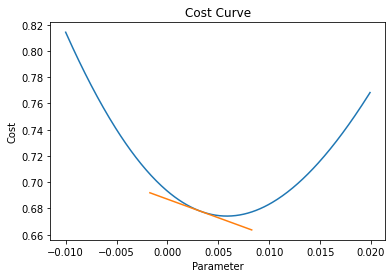

In [10]:
# Use gradient descent to update b
learning_rate = 0.0005
b -= (learning_rate * slope[1])

# Solve for the derivative of the cost curve 
observations_ = len(features_)
parameters_ = np.array([0, b])
predictions_ = predict(features_, parameters_)
slope = np.matmul(features_.T, predictions_-target_)
slope /= observations_
cost = cost_logistic_regression(features_, parameters_, target_)
print(f'Using the equation above the slope of the cost curve at b = {b} is {round(slope[1],2)}')

# Plot tangential line to cost curve at next iteration of b
dummy_b, dummy_cost = compute_tangent(b, cost, slope[1])
fig, ax = plt.subplots()
ax.plot(sample_parameters, costs)
ax.plot(dummy_b, dummy_cost)
ax.set(title='Cost Curve', xlabel='Parameter', ylabel='Cost')
plt.show()

Given the partial derivative approaches 0 as the parameter value approachs its optimal value the steps taken by gradient descent get smaller & smaller the closer we get to the optimal value.

In the definition above it referenced that gradient descent takes iterative steps from a defined starting point. How do we know if our starting value is greater or less than the optimal value? In our simplified example the starting point doesn't matter. 

* If our initial value is less than the optimal value the slope is negative so we will add to the paramater value thereby descending down the cost curve.
* If our initial value is greater than the optimal value the slope is positive so we will subtract from the paramater value and again descend down the cost curve.

So the partial derivative will dictate whether we adjust our parameter value up or down and the learning rate dictates the size of the step we take. If we set the learning rate too high we may step over the optimum value of our parameter. If the learning rate is too small we may not take large enough steps to reach the optimum value at all. Printing out the cost for each iterative step will give you an idea of whether you have an appropriate learning rate.

And for now that's all there is to it.

I hope this explanation gives you an understanding of how gradient descent works, there are additional complexities concerning the convexity of the cost function but that is beyond the scope of this post and at present my understanding.

### Prediction ###

I'm going to put all this together and fit the parameters for our survival model using the logic discussed.

Iteration: 0 Cost = 0.6931471805599453
Iteration: 1000 Cost = 0.5147202499720835
Iteration: 2000 Cost = 0.48493413038897143
Iteration: 3000 Cost = 0.4741109111911492
Iteration: 4000 Cost = 0.4684127157476476
Iteration: 5000 Cost = 0.46461948332196773
Iteration: 6000 Cost = 0.46178889629083847
Iteration: 7000 Cost = 0.45956524586232356
Iteration: 8000 Cost = 0.4577736148527668
Iteration: 9000 Cost = 0.45630823782903923
Iteration: 10000 Cost = 0.4550968746517061
The Model Accuracy on the traing data = 0.7833894500561167


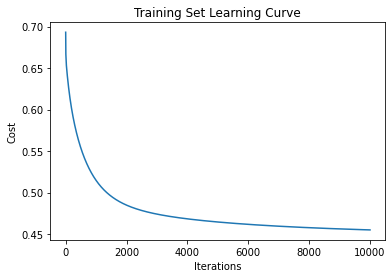

In [11]:
# Update parameters with a learning rate and set of partial derivatives 
def update_parameters(features, parameters, target, learning_rate):
    observations = len(features)
    predictions = predict(features,parameters)
    slopes = np.matmul(features.T, predictions - target)
    slopes /= observations
    slopes *= learning_rate
    parameters -= slopes  
    return parameters

# Update the parameters with gradient descent by the number of iterations
def gradient_descent(features, parameters, target, learning_rate, iterations):
    log = []
    for i in range(iterations):
        cost = cost_logistic_regression(features, parameters, target)
        parameters = update_parameters(features, parameters, target, learning_rate)
        log.append(cost)
        if i % 1000 == 0:
            print('Iteration: ' + str(i) + ' Cost = ' + str(cost))
    return parameters, log  

# Fit model parameters on the training data
model_parameters, log = gradient_descent(features, parameters, target, 0.008, 10001)

# Make predictions on the training data
predictions = predict(features,model_parameters)
threshold = 0.50
binary_predictions = [1 if prediction >= threshold else 0 for prediction in predictions]

# Compute model accurancy 
accurancy = sum(target == binary_predictions)/len(target)
print(f'The Model Accuracy on the training data = {accurancy}')

# Plot learning curve
fig, ax = plt.subplots()
ax.plot(log)
ax.set(title='Training Set Learning Curve', xlabel='Iterations', ylabel='Cost')
plt.show()

Finally let's have a look at how this model compares to an implemention with Sklearn. The results are roughly the same, if run gradient descent 100,000 times the alignment is 100% but thats overkill so I'm to give myself a pass.

In [12]:
# Fit a logistic regression using Sklearn on the same training data
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='none', max_iter=5001).fit(features, target)
sk_predictions = logreg.predict(features)
alinement = sum(binary_predictions == sk_predictions)/len(sk_predictions)

# Compare models
print(f'The percentage fit between predictions and those of logit with Sklearn is {round(alinement,2)} ')
print('Comparing specific parameters fit:')
for b, sk_b, param in zip(parameters, logreg.coef_[0], feature_names):
    b = str(round(b,1))
    sk_b = str(round(sk_b,1))
    print(f'Parameter {param}: Model {b} Sklearn {sk_b} ')

The percentage fit between predictions and those of logit with Sklearn is 0.96 
Comparing specific parameters fit:
Parameter Bias Term: Model 1.1 Sklearn 1.3 
Parameter Pclass: Model -0.8 Sklearn -1.2 
Parameter Age: Model -0.0 Sklearn -0.0 
Parameter Sex_female: Model 1.8 Sklearn 1.9 
Parameter Sex_male: Model -0.7 Sklearn -0.7 
Parameter Embarked_C: Model 0.7 Sklearn 0.6 
Parameter Embarked_Q: Model 0.2 Sklearn 0.6 
Parameter Embarked_S: Model 0.2 Sklearn 0.1 
